In [1]:
# Import libraries i will need
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from osgeo import gdal
import random as python_random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization
import gc
import keras

#import the libraries necessary for confusion plot
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Model
from matplotlib import colors


In [2]:
# Grab the paths to all of the images in the 20m buffer folder
inputPath="../data/processed/cam-2017-20m" # 5495 files
filelist = []

# Load the images, and append them to a list.
for filepath in os.listdir(inputPath):
    if filepath.endswith((".tif")):
    #print(filepath)
        tempfile=inputPath+'/{0}'.format(filepath)
        filelist.append(tempfile)

In [3]:
len(filelist) # 5495 files

5495

In [4]:
# Create a list with all of the images as arrays
images = []

# Generate data
for i, ID in enumerate(filelist):
    # Store sample
    dataset = gdal.Open(ID)
    image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
    images.append(image)  # Append the NumPy array to the list.

In [5]:
# Make images into on big array and then transpose for use in ML model
all_data= np.stack(images, axis= 0)
all_data = np.transpose(all_data, axes=[0, 2, 3, 1])
# normalize values of the input data to 0,1
all_data = all_data/255

In [6]:
all_data.shape

(5495, 160, 160, 3)

In [6]:
all_data[1].shape

(160, 160, 3)

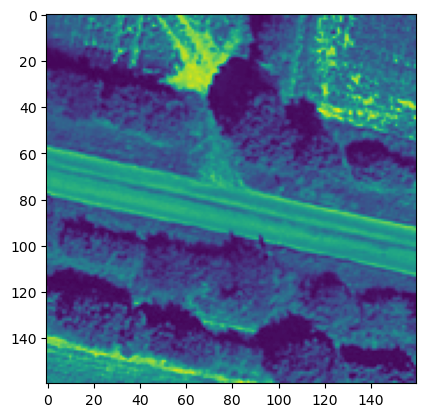

In [7]:
plt.imshow(all_data[1,:,:,1])

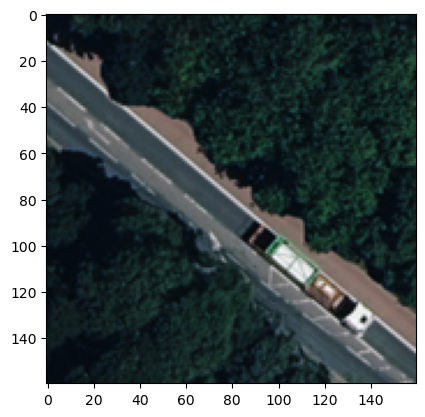

In [8]:
plt.imshow(all_data[4432])


In [46]:
# function to display images
def display(array1, array2, array3):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices]
    images3 = array3[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(5, n, i + 1)
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(5, n, i + 1 + n + n)
        plt.imshow(image3)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

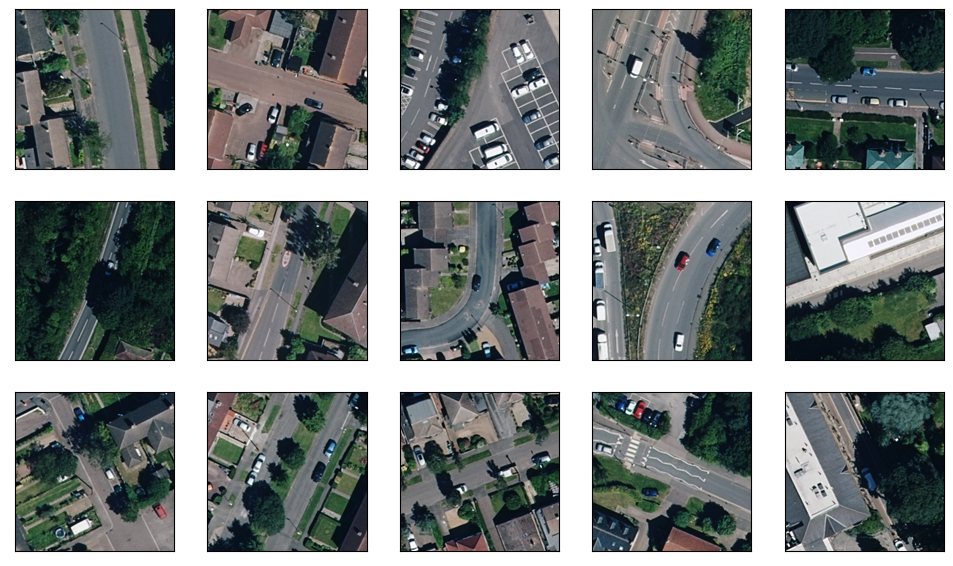

In [47]:
display(all_data,all_data,all_data)

# Basic Autoencoder 

In [6]:
# lets take like 500 images, split into train/test and then see what a basic autoencoder can do
data_subset =all_data[:500]
data_subset.shape

(500, 160, 160, 3)

In [7]:
# split up the data into train/val
np.random.seed(14)
mask = np.random.rand(len(data_subset)) <=.7

training_data = np.array(data_subset)[mask]
val_data = np.array(data_subset)[~mask]

In [11]:
input_img = keras.Input(shape=training_data.shape[1:])
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)
encoded = layers.Dense(8, activation='relu')(encoded)
encoded = layers.Dense(1, activation='relu')(encoded)


decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.Dense(16, activation='relu')(decoded)
decoded = layers.Dense(32, activation='relu')(decoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(3, activation='relu')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', metrics=["mae",'accuracy'],loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 dense (Dense)               (None, 160, 160, 128)     512       
                                                                 
 dense_1 (Dense)             (None, 160, 160, 64)      8256      
                                                                 
 dense_2 (Dense)             (None, 160, 160, 32)      2080      
                                                                 
 dense_3 (Dense)             (None, 160, 160, 16)      528       
                                                                 
 dense_4 (Dense)             (None, 160, 160, 8)       136       
                                                                 
 dense_5 (Dense)             (None, 160, 160, 1)       9     

In [12]:
input_img = keras.Input(shape=training_data.shape[1:])
encoded = layers.Dense(64, activation='relu')(input_img)
encoded= layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)
encoded= layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = layers.Dense(8, activation='relu')(encoded)
encoded= layers.MaxPooling2D((2, 2), padding='same')(encoded)
encoded = layers.Dense(1, activation='relu')(encoded)


decoded = layers.Dense(8, activation='relu')(encoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Dense(16, activation='relu')(decoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.UpSampling2D((2, 2))(decoded)
decoded = layers.Dense(3, activation='relu')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', metrics=["mae",'accuracy'],loss='mean_squared_error')
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 dense_12 (Dense)            (None, 160, 160, 64)      256       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 64)       0         
 )                                                               
                                                                 
 dense_13 (Dense)            (None, 80, 80, 16)        1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 dense_14 (Dense)            (None, 40, 40, 8)         136 

In [13]:
gc.collect()

968

In [14]:
%%time
history = autoencoder.fit(x=training_data, y=training_data, epochs=20,batch_size=20,
                validation_data=[val_data, val_data])

Epoch 1/20
18/18 [==============================] - 5s 67ms/step - loss: 0.1265 - mae: 0.2980 - accuracy: 0.3158 - val_loss: 0.1082 - val_mae: 0.2651 - val_accuracy: 0.3054
Epoch 2/20
18/18 [==============================] - 1s 50ms/step - loss: 0.0702 - mae: 0.2063 - accuracy: 0.3196 - val_loss: 0.0429 - val_mae: 0.1665 - val_accuracy: 0.3054
Epoch 3/20
18/18 [==============================] - 1s 50ms/step - loss: 0.0344 - mae: 0.1526 - accuracy: 0.3027 - val_loss: 0.0330 - val_mae: 0.1530 - val_accuracy: 0.1631
Epoch 4/20
18/18 [==============================] - 1s 51ms/step - loss: 0.0290 - mae: 0.1414 - accuracy: 0.3625 - val_loss: 0.0274 - val_mae: 0.1368 - val_accuracy: 0.3483
Epoch 5/20
18/18 [==============================] - 1s 52ms/step - loss: 0.0230 - mae: 0.1220 - accuracy: 0.3231 - val_loss: 0.0210 - val_mae: 0.1162 - val_accuracy: 0.3054
Epoch 6/20
18/18 [==============================] - 1s 51ms/step - loss: 0.0189 - mae: 0.1083 - accuracy: 0.3196 - val_loss: 0.0182 - v

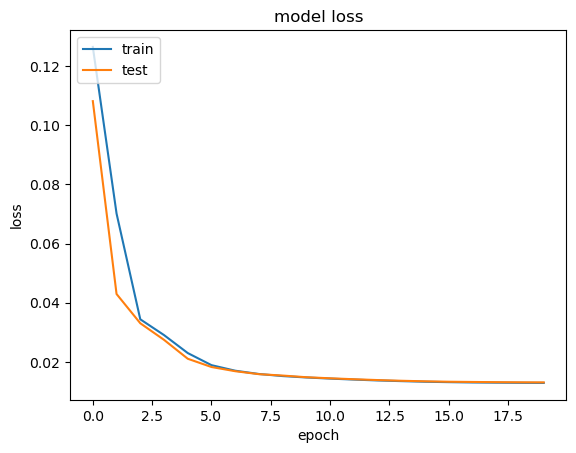

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

5/5 [==============================] - 1s 19ms/step


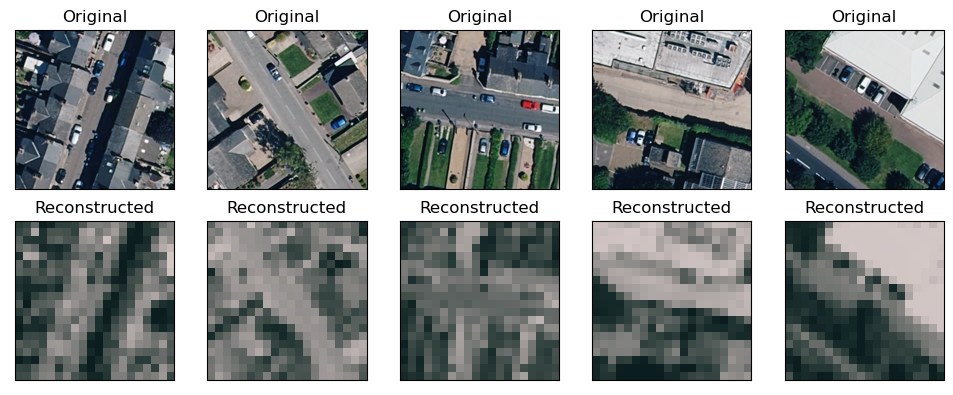

In [16]:
pred_data=autoencoder.predict(val_data)

def display(array1, array2):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(5, n, i + 1)
        plt.title("Original")
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.title("Reconstructed")
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    plt.show()

display(val_data, pred_data)

# Convolutional Autoencoder 

In [17]:
input_img = keras.Input(shape=(160, 160, 3))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

#x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(encoded)
#x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

cae = keras.Model(input_img, decoded)
cae.compile(optimizer='adam',metrics=["mae",'accuracy'], loss='mean_squared_error')
cae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 4)         580 

In [12]:
input_img = keras.Input(shape=(160, 160, 3))

x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((4, 4), padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((5, 5), padding='same')(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)


# x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(12, (3, 3), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(x)
# #encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

#x = layers.Conv2D(1, (3, 3), activation='relu', padding='same')(encoded)
#x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((5, 5))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
decoded = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(x)

cae = keras.Model(input_img, decoded)
cae.compile(optimizer='adam',metrics=["mae",'accuracy'], loss='mean_squared_error')
cae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv2d_40 (Conv2D)          (None, 160, 160, 64)      1792      
                                                                 
 conv2d_41 (Conv2D)          (None, 160, 160, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 40, 40, 64)       0         
 2D)                                                             
                                                                 
 conv2d_42 (Conv2D)          (None, 40, 40, 128)       73856     
                                                                 
 conv2d_43 (Conv2D)          (None, 40, 40, 128)       147584    
                                                           

In [13]:
gc.collect()

3170

In [14]:
%%time
callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True,
                                           mode="max", verbose=1)

history = cae.fit(x=training_data, y=training_data,batch_size=10, epochs=10,
                validation_data=[val_data, val_data],shuffle=True)

Epoch 1/10
36/36 [==============================] - 269s 7s/step - loss: 172.1031 - mae: 1.4391 - accuracy: 0.3303 - val_loss: 0.0413 - val_mae: 0.1702 - val_accuracy: 0.3070
Epoch 2/10
36/36 [==============================] - 275s 8s/step - loss: 0.0388 - mae: 0.1636 - accuracy: 0.3765 - val_loss: 0.0440 - val_mae: 0.1762 - val_accuracy: 0.4586
Epoch 3/10
36/36 [==============================] - 283s 8s/step - loss: 0.0393 - mae: 0.1645 - accuracy: 0.3810 - val_loss: 0.0408 - val_mae: 0.1693 - val_accuracy: 0.3085
Epoch 4/10
36/36 [==============================] - 275s 8s/step - loss: 0.0393 - mae: 0.1643 - accuracy: 0.3228 - val_loss: 0.0405 - val_mae: 0.1688 - val_accuracy: 0.3088
Epoch 5/10
36/36 [==============================] - 269s 7s/step - loss: 0.0381 - mae: 0.1625 - accuracy: 0.3208 - val_loss: 0.0411 - val_mae: 0.1709 - val_accuracy: 0.3068
Epoch 6/10
36/36 [==============================] - 269s 7s/step - loss: 0.0379 - mae: 0.1621 - accuracy: 0.3510 - val_loss: 0.0410 -

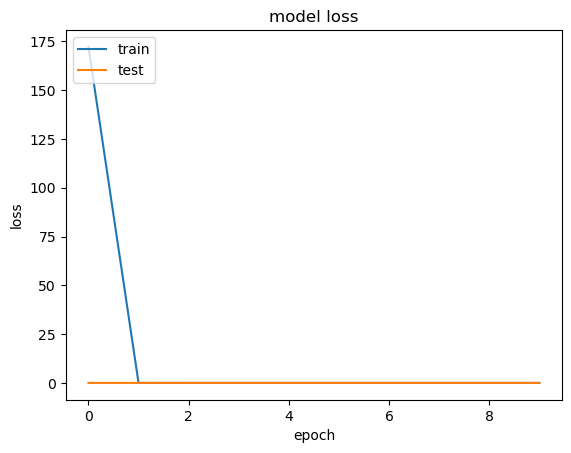

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

5/5 [==============================] - 19s 4s/step


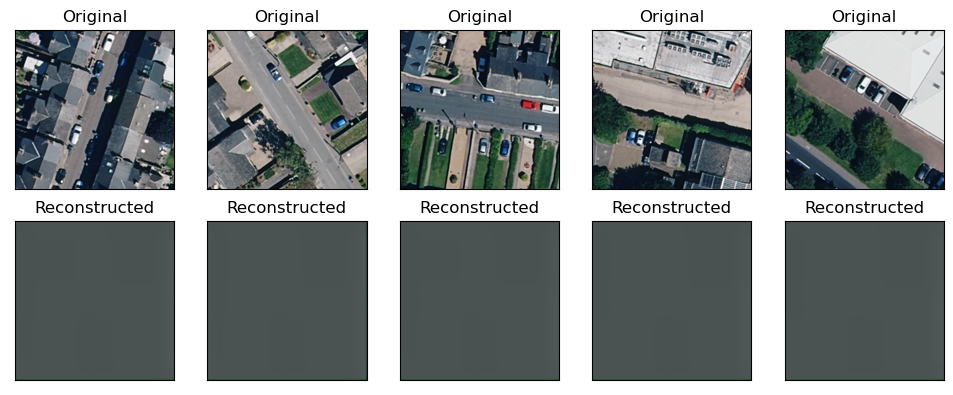

In [16]:
pred_data=cae.predict(val_data)
def display(array1, array2):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(5, n, i + 1)
        plt.title("Original")
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.title("Reconstructed")
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    plt.show()
display(val_data, pred_data)

# Transfer Learning 


In [6]:
# Try out EfficientNetV2M
from tensorflow.keras.applications import EfficientNetV2M

In [7]:
### NOTE: needs data to be 0-255
# Make images into on big array and then transpose for use in ML model
all_data= np.stack(images, axis= 0)
all_data = np.transpose(all_data, axes=[0, 2, 3, 1])
# lets take like 500 images, split into train/test and then see what a basic autoencoder can do
data_subset =all_data[:1000]
data_subset.shape

# split up the data into train/val
np.random.seed(14)
mask = np.random.rand(len(data_subset)) <=.7

training_data = np.array(data_subset)[mask]
val_data = np.array(data_subset)[~mask]

In [8]:
base_model = EfficientNetV2M(weights="imagenet", include_top=False, input_shape=training_data[0].shape)

In [9]:
base_model.trainable = False ## Not trainable weights
base_model.summary()

Model: "efficientnetv2-m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 80, 80, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 80, 80, 24)   96          ['stem_conv[0][0]'

                                                                                                  
 block2b_add (Add)              (None, 40, 40, 48)   0           ['block2b_drop[0][0]',           
                                                                  'block2a_project_bn[0][0]']     
                                                                                                  
 block2c_expand_conv (Conv2D)   (None, 40, 40, 192)  82944       ['block2b_add[0][0]']            
                                                                                                  
 block2c_expand_bn (BatchNormal  (None, 40, 40, 192)  768        ['block2c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block2c_expand_activation (Act  (None, 40, 40, 192)  0          ['block2c_expand_bn[0][0]']      
 ivation) 

 block3b_project_conv (Conv2D)  (None, 20, 20, 80)   25600       ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 20, 20, 80)  320         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 20, 20, 80)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 20, 20, 80)   0           ['block3b_drop[0][0]',           
                                                                  'block3a_project_bn[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 320)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 320)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 20)     6420        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 320)    6720        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 10, 10, 640)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 10, 10, 160)  102400      ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 10, 10, 160)  640        ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 10, 10, 160)  0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block4e_project_bn (BatchNorma  (None, 10, 10, 160)  640        ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 10, 10, 160)  0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 10, 10, 160)  0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block4f_expand_conv (Conv2D)   (None, 10, 10, 640)  102400      ['block4e_add[0][0]']            
          

                                                                                                  
 block4g_add (Add)              (None, 10, 10, 160)  0           ['block4g_drop[0][0]',           
                                                                  'block4f_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 10, 10, 960)  153600      ['block4g_add[0][0]']            
                                                                                                  
 block5a_expand_bn (BatchNormal  (None, 10, 10, 960)  3840       ['block5a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5a_expand_activation (Act  (None, 10, 10, 960)  0          ['block5a_expand_bn[0][0]']      
 ivation) 

                                                                                                  
 block5c_expand_activation (Act  (None, 10, 10, 1056  0          ['block5c_expand_bn[0][0]']      
 ivation)                       )                                                                 
                                                                                                  
 block5c_dwconv2 (DepthwiseConv  (None, 10, 10, 1056  9504       ['block5c_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5c_bn (BatchNormalization  (None, 10, 10, 1056  4224       ['block5c_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5c_a

                                                                                                  
 block5e_dwconv2 (DepthwiseConv  (None, 10, 10, 1056  9504       ['block5e_expand_activation[0][0]
 2D)                            )                                ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 10, 10, 1056  4224       ['block5e_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5e_activation (Activation  (None, 10, 10, 1056  0          ['block5e_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5e_s

                                                                                                  
 block5g_bn (BatchNormalization  (None, 10, 10, 1056  4224       ['block5g_dwconv2[0][0]']        
 )                              )                                                                 
                                                                                                  
 block5g_activation (Activation  (None, 10, 10, 1056  0          ['block5g_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5g_se_squeeze (GlobalAver  (None, 1056)        0           ['block5g_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5g_s

                                                                                                  
 block5i_activation (Activation  (None, 10, 10, 1056  0          ['block5i_bn[0][0]']             
 )                              )                                                                 
                                                                                                  
 block5i_se_squeeze (GlobalAver  (None, 1056)        0           ['block5i_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5i_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5i_se_squeeze[0][0]']     
                                                                                                  
 block5i_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5i_se_reshape[0][0]']     
          

                                                                                                  
 block5k_se_squeeze (GlobalAver  (None, 1056)        0           ['block5k_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5k_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5k_se_squeeze[0][0]']     
                                                                                                  
 block5k_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5k_se_reshape[0][0]']     
                                                                                                  
 block5k_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block5k_se_reduce[0][0]']      
                                                                                                  
 block5k_s

                                                                                                  
 block5m_se_reshape (Reshape)   (None, 1, 1, 1056)   0           ['block5m_se_squeeze[0][0]']     
                                                                                                  
 block5m_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block5m_se_reshape[0][0]']     
                                                                                                  
 block5m_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block5m_se_reduce[0][0]']      
                                                                                                  
 block5m_se_excite (Multiply)   (None, 10, 10, 1056  0           ['block5m_activation[0][0]',     
                                )                                 'block5m_se_expand[0][0]']      
                                                                                                  
 block5m_p

 block6a_se_reduce (Conv2D)     (None, 1, 1, 44)     46508       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 1056)   47520       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 5, 5, 1056)   0           ['block6a_activation[0][0]',     
                                                                  'block6a_se_expand[0][0]']      
                                                                                                  
 block6a_project_conv (Conv2D)  (None, 5, 5, 304)    321024      ['block6a_se_excite[0][0]']      
                                                                                                  
 block6a_project_bn (BatchNorma  (None, 5, 5, 304)   1216        ['block6a_project_conv[0][0]']   
 lization)

 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 5, 5, 304)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 5, 5, 304)    0           ['block6c_drop[0][0]',           
                                                                  'block6b_add[0][0]']            
                                                                                                  
 block6d_expand_conv (Conv2D)   (None, 5, 5, 1824)   554496      ['block6c_add[0][0]']            
                                                                                                  
 block6d_expand_bn (BatchNormal  (None, 5, 5, 1824)  7296        ['block6d_expand_conv[0][0]']    
 ization) 

                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 5, 5, 1824)   554496      ['block6e_add[0][0]']            
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 5, 5, 1824)  7296        ['block6f_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6f_expand_activation (Act  (None, 5, 5, 1824)  0           ['block6f_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6f_d

 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 5, 5, 1824)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6h_dwconv2 (DepthwiseConv  (None, 5, 5, 1824)  16416       ['block6h_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6h_bn (BatchNormalization  (None, 5, 5, 1824)  7296        ['block6h_dwconv2[0][0]']        
 )                                                                                                
          

 block6j_dwconv2 (DepthwiseConv  (None, 5, 5, 1824)  16416       ['block6j_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block6j_bn (BatchNormalization  (None, 5, 5, 1824)  7296        ['block6j_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block6j_activation (Activation  (None, 5, 5, 1824)  0           ['block6j_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6j_se_squeeze (GlobalAver  (None, 1824)        0           ['block6j_activation[0][0]']     
 agePoolin

                                                                                                  
 block6l_activation (Activation  (None, 5, 5, 1824)  0           ['block6l_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6l_se_squeeze (GlobalAver  (None, 1824)        0           ['block6l_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6l_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6l_se_squeeze[0][0]']     
                                                                                                  
 block6l_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6l_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6n_se_reshape (Reshape)   (None, 1, 1, 1824)   0           ['block6n_se_squeeze[0][0]']     
                                                                                                  
 block6n_se_reduce (Conv2D)     (None, 1, 1, 76)     138700      ['block6n_se_reshape[0][0]']     
                                                                                                  
 block6n_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6n_se_reduce[0][0]']      
                                                                                                  
 block6n_se_excite (Multiply)   (None, 5, 5, 1824)   0           ['block6n_activation[0][0]',     
                                                                  'block6n_se_expand[0][0]']      
          

                                                                                                  
 block6p_se_expand (Conv2D)     (None, 1, 1, 1824)   140448      ['block6p_se_reduce[0][0]']      
                                                                                                  
 block6p_se_excite (Multiply)   (None, 5, 5, 1824)   0           ['block6p_activation[0][0]',     
                                                                  'block6p_se_expand[0][0]']      
                                                                                                  
 block6p_project_conv (Conv2D)  (None, 5, 5, 304)    554496      ['block6p_se_excite[0][0]']      
                                                                                                  
 block6p_project_bn (BatchNorma  (None, 5, 5, 304)   1216        ['block6p_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6r_project_conv (Conv2D)  (None, 5, 5, 304)    554496      ['block6r_se_excite[0][0]']      
                                                                                                  
 block6r_project_bn (BatchNorma  (None, 5, 5, 304)   1216        ['block6r_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6r_drop (Dropout)         (None, 5, 5, 304)    0           ['block6r_project_bn[0][0]']     
                                                                                                  
 block6r_add (Add)              (None, 5, 5, 304)    0           ['block6r_drop[0][0]',           
                                                                  'block6q_add[0][0]']            
          

                                                                                                  
 block7c_expand_conv (Conv2D)   (None, 5, 5, 3072)   1572864     ['block7b_add[0][0]']            
                                                                                                  
 block7c_expand_bn (BatchNormal  (None, 5, 5, 3072)  12288       ['block7c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7c_expand_activation (Act  (None, 5, 5, 3072)  0           ['block7c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7c_dwconv2 (DepthwiseConv  (None, 5, 5, 3072)  27648       ['block7c_expand_activation[0][0]
 2D)      

                                                                                                  
 block7e_expand_activation (Act  (None, 5, 5, 3072)  0           ['block7e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7e_dwconv2 (DepthwiseConv  (None, 5, 5, 3072)  27648       ['block7e_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block7e_bn (BatchNormalization  (None, 5, 5, 3072)  12288       ['block7e_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block7e_a

In [73]:
# add the specific layers for my problem
tl_model = models.Sequential([
    base_model,
    layers.MaxPooling2D((5, 5), padding='same'),
    layers.UpSampling2D((5,5)),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(3, (3, 3), activation='linear', padding='same'),
])

tl_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 5, 5, 1280)       53150388  
 l)                                                              
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 1, 1, 1280)       0         
 g2D)                                                            
                                                                 
 up_sampling2d_91 (UpSamplin  (None, 5, 5, 1280)       0         
 g2D)                                                            
                                                                 
 conv2d_111 (Conv2D)         (None, 5, 5, 128)         1474688   
                                                                 
 up_sampling2d_92 (UpSamplin  (None, 10, 10, 128)      0         
 g2D)                                                

In [74]:
tl_model.compile(optimizer='adam', metrics=["mae",'accuracy'], loss='mean_squared_error')

In [75]:
gc.collect()

23978

In [76]:
%%time
history = tl_model.fit(x=training_data, y=training_data,batch_size=20, epochs=40,
                validation_data=[val_data, val_data],shuffle=True)

Epoch 1/40
36/36 [==============================] - 22s 256ms/step - loss: 3980.2527 - mae: 49.8700 - accuracy: 0.3747 - val_loss: 2796.7510 - val_mae: 43.2764 - val_accuracy: 0.4051
Epoch 2/40
36/36 [==============================] - 5s 150ms/step - loss: 2735.4338 - mae: 42.8277 - accuracy: 0.3480 - val_loss: 2626.5381 - val_mae: 42.4113 - val_accuracy: 0.3360
Epoch 3/40
36/36 [==============================] - 5s 151ms/step - loss: 2701.8884 - mae: 42.5241 - accuracy: 0.3477 - val_loss: 2600.6423 - val_mae: 41.9069 - val_accuracy: 0.3310
Epoch 4/40
36/36 [==============================] - 5s 151ms/step - loss: 2521.3611 - mae: 41.3080 - accuracy: 0.3387 - val_loss: 2570.8521 - val_mae: 41.6914 - val_accuracy: 0.3290
Epoch 5/40
36/36 [==============================] - 5s 151ms/step - loss: 2471.7012 - mae: 40.8512 - accuracy: 0.3351 - val_loss: 2561.7627 - val_mae: 41.9036 - val_accuracy: 0.3310
Epoch 6/40
36/36 [==============================] - 5s 152ms/step - loss: 2434.2925 - mae

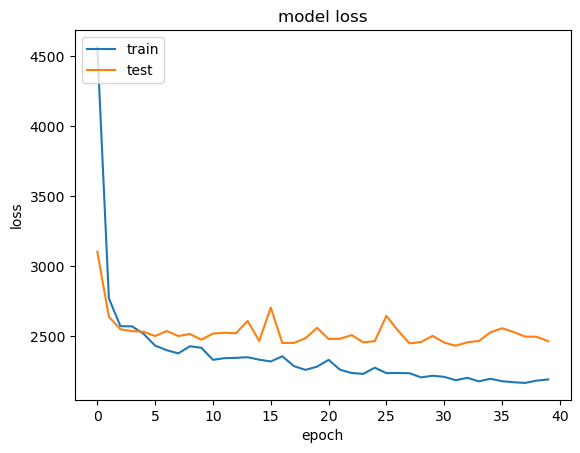

In [71]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

9/9 [==============================] - 5s 142ms/step


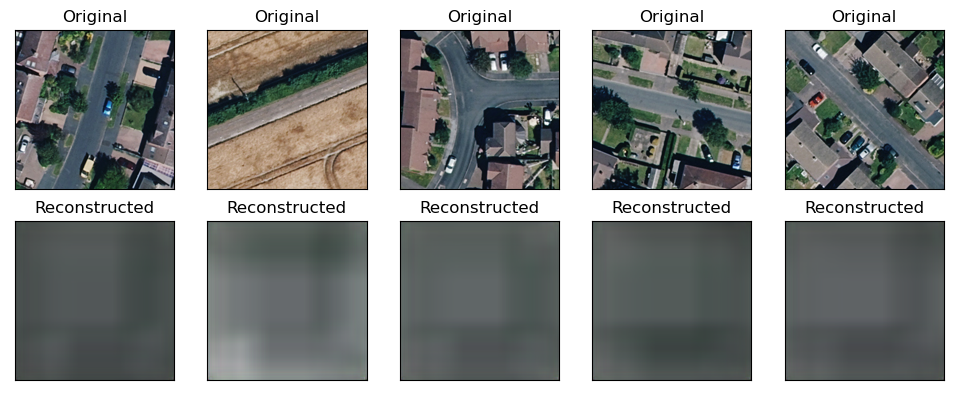

In [72]:
pred_data=tl_model.predict(val_data)

def display(array1, array2):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]/255
    images2 = array2[indices]/255

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(5, n, i + 1)
        plt.title("Original")
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.title("Reconstructed")
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    plt.show()

display(val_data, pred_data)

In [16]:
# Try out EfficientNetV2M
from tensorflow.keras.applications import VGG16

In [28]:
# Make images into on big array and then transpose for use in ML model
all_data= np.stack(images, axis= 0)
all_data = np.transpose(all_data, axes=[0, 2, 3, 1])
#all_data = all_data/255
# lets take like 500 images, split into train/test and then see what a basic autoencoder can do
data_subset =all_data[:500]
data_subset.shape

# split up the data into train/val
np.random.seed(14)
mask = np.random.rand(len(data_subset)) <=.7

training_data = np.array(data_subset)[mask]
val_data = np.array(data_subset)[~mask]

In [29]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=training_data[0].shape)

base_model.trainable = False ## Not trainable weights
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [39]:
# add the specific layers for my problem
tl_model = models.Sequential([
    base_model,
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D(),
    layers.Conv2D(3, (3, 3), activation='relu', padding='same'),
])

tl_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 conv2d_17 (Conv2D)          (None, 5, 5, 256)         1179904   
                                                                 
 up_sampling2d_15 (UpSamplin  (None, 10, 10, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 10, 10, 128)       295040    
                                                                 
 up_sampling2d_16 (UpSamplin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 20, 20, 64)       

In [40]:
tl_model.compile(optimizer='adam', metrics=["mae",'accuracy'], loss='mean_squared_error')

In [41]:
gc.collect()

21718

In [42]:
%%time
history = tl_model.fit(x=training_data, y=training_data,batch_size=20, epochs=25,
                validation_data=[val_data, val_data],shuffle=True)

Epoch 1/25
18/18 [==============================] - 3s 149ms/step - loss: 4245.3125 - mae: 51.1947 - accuracy: 0.3025 - val_loss: 2632.8386 - val_mae: 40.5787 - val_accuracy: 0.4511
Epoch 2/25
18/18 [==============================] - 2s 136ms/step - loss: 2154.9988 - mae: 36.7139 - accuracy: 0.4171 - val_loss: 2168.7246 - val_mae: 37.3322 - val_accuracy: 0.3096
Epoch 3/25
18/18 [==============================] - 2s 136ms/step - loss: 1881.9034 - mae: 34.1627 - accuracy: 0.3763 - val_loss: 2175.0098 - val_mae: 36.8859 - val_accuracy: 0.3656
Epoch 4/25
18/18 [==============================] - 2s 137ms/step - loss: 1739.4532 - mae: 32.6812 - accuracy: 0.3737 - val_loss: 2041.6469 - val_mae: 35.8483 - val_accuracy: 0.3432
Epoch 5/25
18/18 [==============================] - 2s 136ms/step - loss: 1645.6410 - mae: 31.5238 - accuracy: 0.3847 - val_loss: 2065.6833 - val_mae: 35.8459 - val_accuracy: 0.3568
Epoch 6/25
18/18 [==============================] - 2s 138ms/step - loss: 1584.8142 - mae:

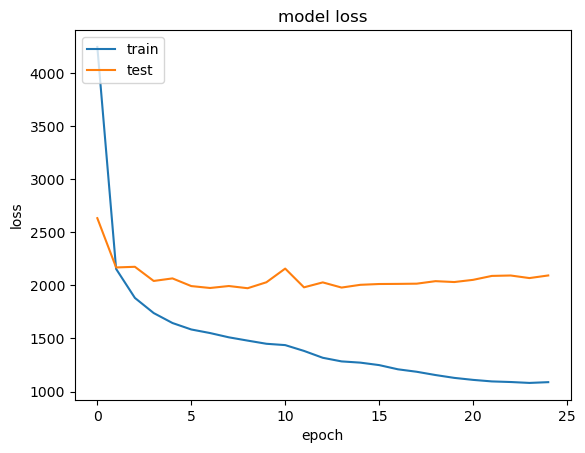

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

7/7 [==============================] - 1s 72ms/step


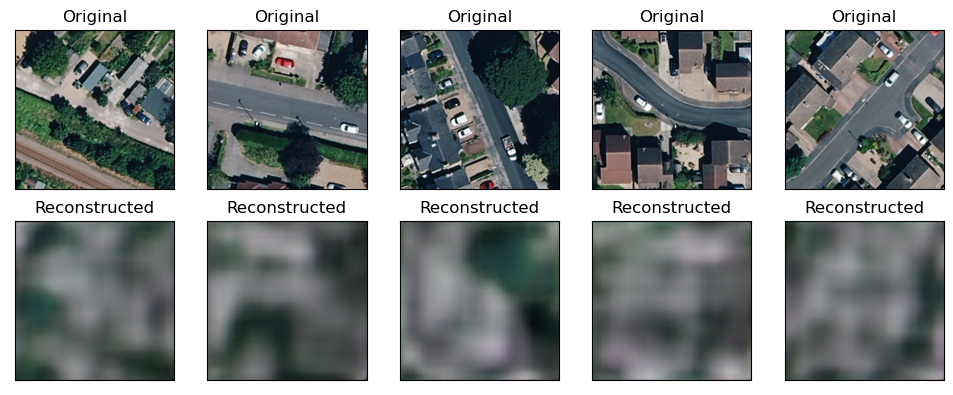

In [44]:
pred_data=tl_model.predict(val_data,batch_size=20)

def display(array1, array2):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]/255
    images2 = array2[indices]/255

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(5, n, i + 1)
        plt.title("Original")
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.title("Reconstructed")
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    plt.show()

display(val_data, pred_data)

# UNet


In [6]:
# Make images into on big array and then transpose for use in ML model
all_data= np.stack(images, axis= 0)
all_data = np.transpose(all_data, axes=[0, 2, 3, 1])
all_data = all_data/255
# lets take like 500 images, split into train/test and then see what a basic autoencoder can do
data_subset =all_data[:500]
data_subset.shape

# split up the data into train/val
np.random.seed(14)
mask = np.random.rand(len(data_subset)) <=.7

training_data = np.array(data_subset)[mask]
val_data = np.array(data_subset)[~mask]

In [7]:
def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = layers.Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
 #   rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
 #   previous_block_activation = rescale  # Set aside residual
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [64, 32]:
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = layers.MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    contraction[f'conv{16}'] = x
    x = layers.MaxPooling2D((2, 2))(x)
    previous_block_activation = x
        
    c5 = layers.Conv2D(1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5
    
    x = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
    x = layers.concatenate([x, contraction[f'conv{16}']])
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation = x
        
    # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([64, 32]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = layers.Conv2D(filters=3, kernel_size=(1, 1), activation="relu")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [8]:
# build model
unet_model= build_unet(img_shape=(160, 160, 3))
unet_model.summary()

unet_model.compile(optimizer="adam", 
              loss='mean_squared_error',
              metrics=["mae",'accuracy'])
#print(model_multi_all_shared.metrics_names)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 160, 160, 64  0           ['conv2d[0][0]']                 
                                )                                                             

In [9]:
%%time

#callback = tf.keras.callbacks.EarlyStopping(monitor="val_tree_binary_mean_io_u", patience=10, restore_best_weights=True,
#                                           mode="max", verbose=1)

# Train our model
history=unet_model.fit(
    x=training_data, 
    y=training_data,
    epochs=50,
    batch_size=10,
    validation_data=[val_data, val_data],
 #   callbacks=callback
)

Epoch 1/50
36/36 [==============================] - 12s 153ms/step - loss: 0.0296 - mae: 0.1126 - accuracy: 0.3910 - val_loss: 0.0035 - val_mae: 0.0432 - val_accuracy: 0.6006
Epoch 2/50
36/36 [==============================] - 5s 144ms/step - loss: 0.0037 - mae: 0.0446 - accuracy: 0.6063 - val_loss: 0.0014 - val_mae: 0.0291 - val_accuracy: 0.8384
Epoch 3/50
36/36 [==============================] - 5s 144ms/step - loss: 0.0022 - mae: 0.0339 - accuracy: 0.7350 - val_loss: 0.0012 - val_mae: 0.0271 - val_accuracy: 0.8759
Epoch 4/50
36/36 [==============================] - 5s 144ms/step - loss: 0.0016 - mae: 0.0293 - accuracy: 0.7630 - val_loss: 0.0016 - val_mae: 0.0320 - val_accuracy: 0.8924
Epoch 5/50
36/36 [==============================] - 5s 144ms/step - loss: 0.0013 - mae: 0.0265 - accuracy: 0.7869 - val_loss: 7.0096e-04 - val_mae: 0.0207 - val_accuracy: 0.9041
Epoch 6/50
36/36 [==============================] - 5s 145ms/step - loss: 0.0011 - mae: 0.0247 - accuracy: 0.8054 - val_loss:

36/36 [==============================] - 5s 145ms/step - loss: 3.0632e-04 - mae: 0.0128 - accuracy: 0.9135 - val_loss: 2.7818e-04 - val_mae: 0.0129 - val_accuracy: 0.9424
Epoch 47/50
36/36 [==============================] - 5s 145ms/step - loss: 2.9134e-04 - mae: 0.0125 - accuracy: 0.9150 - val_loss: 1.0810e-04 - val_mae: 0.0077 - val_accuracy: 0.9434
Epoch 48/50
36/36 [==============================] - 5s 145ms/step - loss: 2.7719e-04 - mae: 0.0122 - accuracy: 0.9158 - val_loss: 1.7041e-04 - val_mae: 0.0099 - val_accuracy: 0.9443
Epoch 49/50
36/36 [==============================] - 5s 146ms/step - loss: 2.7101e-04 - mae: 0.0121 - accuracy: 0.9168 - val_loss: 1.8554e-04 - val_mae: 0.0103 - val_accuracy: 0.9420
Epoch 50/50
36/36 [==============================] - 5s 145ms/step - loss: 2.6410e-04 - mae: 0.0119 - accuracy: 0.9176 - val_loss: 1.8037e-04 - val_mae: 0.0101 - val_accuracy: 0.9436
CPU times: total: 4min 49s
Wall time: 4min 35s


In [25]:
gc.collect()

649

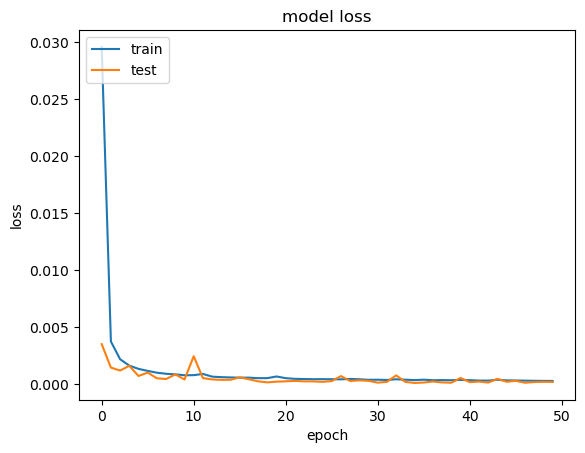

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

7/7 [==============================] - 2s 61ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


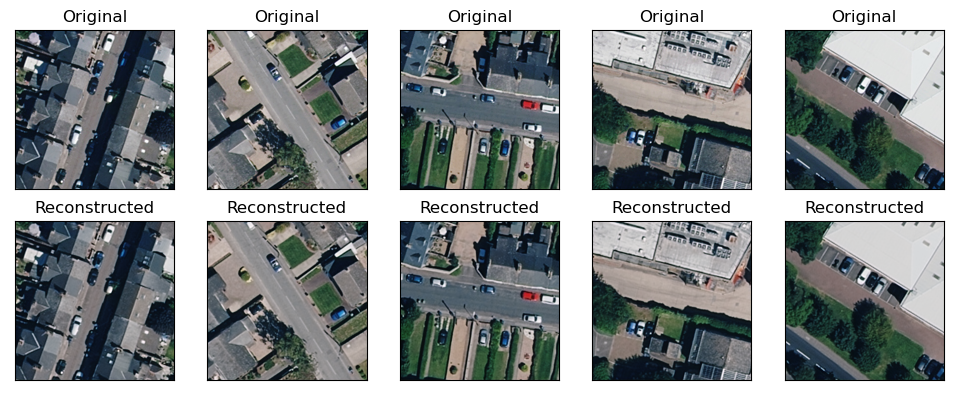

In [11]:
pred_data=unet_model.predict(val_data,batch_size=20)

def display(array1, array2):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(5, n, i + 1)
        plt.title("Original")
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.title("Reconstructed")
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    plt.show()

display(val_data, pred_data)

# Feature Extraction from an autoencoder

In [17]:
layer_name = unet_model.layers[13].name
print(layer_name)

conv2d_6


In [24]:
intermediate_model =Model(inputs=unet_model.input, outputs=unet_model.layers[14].output)
#Then, you can get the output like this:

In [26]:
feature_vectors = intermediate_model.predict(all_data[:2200], batch_size=10)

220/220 [==============================] - 2s 9ms/step


In [27]:
feature_vectors.shape

(2200, 20, 20, 1)

In [28]:
# reshape the feature space into something resembling row/cols
myfeatures=feature_vectors.reshape(-1,400)

In [29]:
# here we create a dataframe we can work with
df_small = pd.DataFrame(myfeatures)
df_small.head()

0         1         2         3         4         5         6    \
0  0.001205  0.005004  0.004743  0.000182  0.007986  0.002908  0.000000   
1  0.002179  0.006240  0.006309  0.000000  0.000000  0.000000  0.000000   
2  0.019810  0.012456  0.004468  0.000000  0.000000  0.005599  0.013208   
3  0.016079  0.023360  0.002660  0.014574  0.000000  0.000000  0.002571   
4  0.010280  0.011240  0.000000  0.000000  0.001415  0.028210  0.015327   

        7         8         9    ...  390       391  392  393  394  395  396  \
0  0.002409  0.009945  0.003346  ...  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
1  0.000000  0.000000  0.000000  ...  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
2  0.000000  0.025515  0.015596  ...  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
3  0.009957  0.007327  0.000000  ...  0.0  0.000000  0.0  0.0  0.0  0.0  0.0   
4  0.021854  0.009842  0.013704  ...  0.0  0.012584  0.0  0.0  0.0  0.0  0.0   

   397  398  399  
0  0.0  0.0  0.0  
1  0.0  0.0  0.0  
2  0.0  0.0  0.0  
3  0.0  0.0  0.0  
4  0.0  0.0  0.0  

[5 rows x 400 columns]

In [30]:
df_small.to_csv("../data/processed/image-features/local_features_20m.csv", encoding='utf-8', index=False)

# Repeat process for larger images

In [11]:
# Grab the paths to all of the images in the 20m buffer folder
inputPath="../data/processed/cam-2017-200m" # 5495 files
filelist = []

# Load the images, and append them to a list.
for filepath in os.listdir(inputPath):
    if filepath.endswith((".tif")):
    #print(filepath)
        tempfile=inputPath+'/{0}'.format(filepath)
        filelist.append(tempfile)

filelist=filelist[:100] # only do 250 for now these are big boys
len(filelist) # 1361 files

100

In [12]:
# Create a list with all of the images as arrays
images = []

# Generate data
for i, ID in enumerate(filelist):
    # Store sample
    dataset = gdal.Open(ID)
    image = dataset.ReadAsArray()  # Returned image is a NumPy array with shape (16, 60, 60) for example.
    images.append(image)  # Append the NumPy array to the list.

# Make images into on big array and then transpose for use in ML model
large_data= np.stack(images, axis= 0)
large_data = np.transpose(large_data, axes=[0, 2, 3, 1])
# normalize values of the input data to 0,1
large_data = large_data/255

In [13]:
large_data.shape

(100, 1600, 1600, 3)

In [7]:
plt.imshow(all_data[80])

NameError: name 'all_data' is not defined

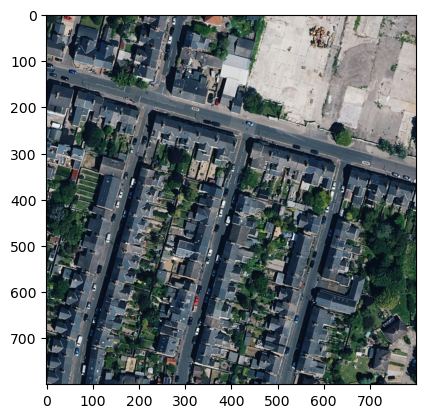

In [6]:
plt.imshow(large_data[80])

In [7]:
# split up the data into train/val
np.random.seed(14)
mask = np.random.rand(len(large_data)) <=.7

training_data = np.array(large_data)[mask]
val_data = np.array(large_data)[~mask]

In [8]:
def build_unet(img_shape):
    # input layer shape is equal to patch image size
    inputs = layers.Input(shape=img_shape)

    # rescale images from (0, 255) to (0, 1)
 #   rescale = Rescaling(scale=1. / 255, input_shape=(img_height, img_width, img_channels))(inputs)
 #   previous_block_activation = rescale  # Set aside residual
    previous_block_activation = inputs

    contraction = {}
    # # Contraction path: Blocks 1 through 5 are identical apart from the feature depth
    for f in [64, 32]:
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
        x = layers.Dropout(0.1)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        contraction[f'conv{f}'] = x
        x = layers.MaxPooling2D((2, 2))(x)
        previous_block_activation = x

    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    contraction[f'conv{16}'] = x
    x = layers.MaxPooling2D((2, 2))(x)
    previous_block_activation = x
        
    c5 = layers.Conv2D(1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(previous_block_activation)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(1, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    previous_block_activation = c5
    
    x = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
    x = layers.concatenate([x, contraction[f'conv{16}']])
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
    previous_block_activation = x
        
    # Expansive path: Second half of the network: upsampling inputs
    # could we use upsampling layers here instead of Conv2dTRanspose layers? might that help
    for f in reversed([64, 32]):
        x = layers.Conv2DTranspose(f, (2, 2), strides=(2, 2), padding='same')(previous_block_activation)
        x = layers.concatenate([x, contraction[f'conv{f}']])
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        previous_block_activation = x

    outputs = layers.Conv2D(filters=3, kernel_size=(1, 1), activation="relu")(previous_block_activation)

    return Model(inputs=inputs, outputs=outputs)

In [9]:
# build model
unet_model= build_unet(img_shape=(800, 800, 3))
unet_model.summary()

unet_model.compile(optimizer="adam", 
              loss='mean_squared_error',
              metrics=["mae",'accuracy'])
#print(model_multi_all_shared.metrics_names)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 800, 800, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 800, 800, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 800, 800, 64  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_12 (Conv2D)             (None, 800, 800, 64  73792       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 dropout_6 (Dropout)            (None, 800, 800, 64  0           ['conv2d_12[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_13 (Conv2D)             (None, 800, 800, 64  36928       ['dropout_6[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_14

In [12]:
%%time

#callback = tf.keras.callbacks.EarlyStopping(monitor="val_tree_binary_mean_io_u", patience=10, restore_best_weights=True,
#                                           mode="max", verbose=1)

# Train our model
history=unet_model.fit(
    x=training_data, 
    y=training_data,
    epochs=20,
    batch_size=5,
    validation_data=[val_data, val_data],
 #   callbacks=callback
)

Epoch 1/20
15/15 [==============================] - 259s 17s/step - loss: 0.0124 - mae: 0.0801 - accuracy: 0.4498 - val_loss: 0.0039 - val_mae: 0.0475 - val_accuracy: 0.6608
Epoch 2/20
15/15 [==============================] - 259s 17s/step - loss: 0.0047 - mae: 0.0498 - accuracy: 0.5988 - val_loss: 0.0023 - val_mae: 0.0357 - val_accuracy: 0.8121
Epoch 3/20
15/15 [==============================] - 256s 17s/step - loss: 0.0032 - mae: 0.0405 - accuracy: 0.6858 - val_loss: 0.0017 - val_mae: 0.0305 - val_accuracy: 0.8327
Epoch 4/20
15/15 [==============================] - 254s 17s/step - loss: 0.0025 - mae: 0.0358 - accuracy: 0.7162 - val_loss: 0.0014 - val_mae: 0.0278 - val_accuracy: 0.8351
Epoch 5/20
15/15 [==============================] - 250s 17s/step - loss: 0.0020 - mae: 0.0325 - accuracy: 0.7387 - val_loss: 0.0013 - val_mae: 0.0272 - val_accuracy: 0.8480
Epoch 6/20
15/15 [==============================] - 252s 17s/step - loss: 0.0017 - mae: 0.0300 - accuracy: 0.7615 - val_loss: 0.00

In [11]:
gc.collect()

1253

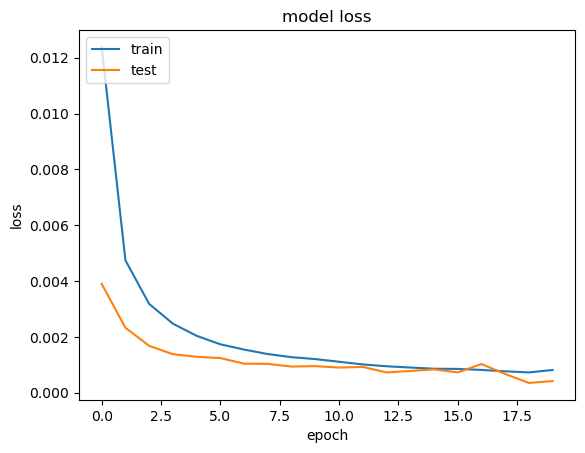

2/2 [==============================] - 16s 4s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


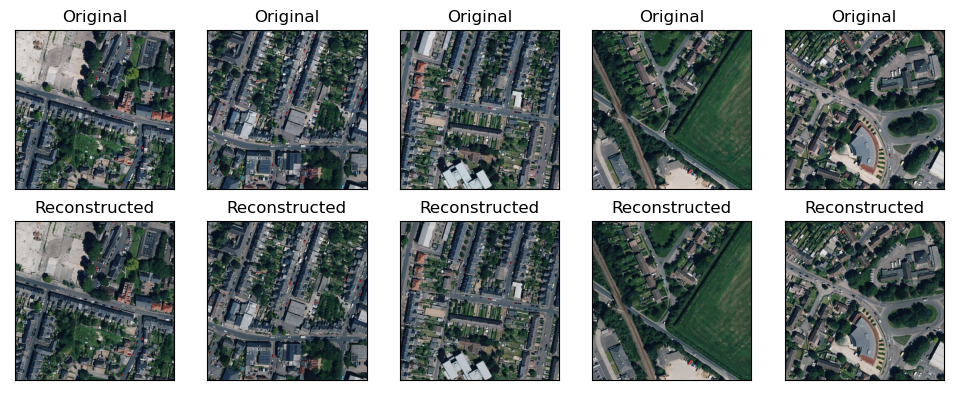

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

pred_data=unet_model.predict(val_data,batch_size=20)

def display(array1, array2):
    """
    Displays 5 random images from each one of the supplied arrays.
    """

    n = 5

    indices = np.random.choice(len(array1), size=n, replace=False)
    images1 = array1[indices]
    images2 = array2[indices]

        
    plt.figure(figsize=(12, 12))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(5, n, i + 1)
        plt.title("Original")
        plt.imshow(image1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(5, n, i + 1 + n)
        plt.title("Reconstructed")
        plt.imshow(image2)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        

    plt.show()

display(val_data, pred_data)

In [14]:
intermediate_model =Model(inputs=unet_model.input, outputs=unet_model.layers[14].output)
#Then, you can get the output like this:

In [22]:
feature_vectors = intermediate_model.predict(large_data, batch_size=10)

feature_vectors.shape

100/100 [==============================] - 144s 1s/step


(1000, 100, 100, 1)

In [25]:
# reshape the feature space into something resembling row/cols
myfeatures=feature_vectors.reshape(-1,10000)
# here we create a dataframe we can work with
df_large = pd.DataFrame(myfeatures)
df_large.head()

0         1         2         3         4         5         6     \
0  0.070402  0.040430  0.031767  0.031081  0.046301  0.066976  0.024759   
1  0.050474  0.000000  0.038055  0.000000  0.000000  0.006756  0.016238   
2  0.048996  0.024623  0.031339  0.051936  0.000000  0.025589  0.023514   
3  0.042698  0.000000  0.025461  0.021107  0.005198  0.007447  0.005551   
4  0.023891  0.009476  0.038914  0.006399  0.000266  0.000000  0.000040   

       7         8         9     ...      9990      9991      9992      9993  \
0  0.015722  0.023196  0.021940  ...  0.003268  0.000000  0.000000  0.001782   
1  0.013577  0.015716  0.013670  ...  0.000000  0.000000  0.000000  0.006987   
2  0.081062  0.000000  0.026476  ...  0.002693  0.033831  0.031421  0.000000   
3  0.051199  0.007671  0.031407  ...  0.000000  0.000000  0.026834  0.056952   
4  0.040400  0.005640  0.026626  ...  0.017827  0.033326  0.007383  0.003979   

       9994      9995      9996      9997      9998      9999  
0  0.000000  0.000351  0.000000  0.000430  0.019142  0.000000  
1  0.008010  0.013388  0.000000  0.010781  0.041079  0.008465  
2  0.000000  0.000000  0.000000  0.012925  0.053861  0.000000  
3  0.001201  0.006320  0.047817  0.052337  0.060615  0.031976  
4  0.027645  0.000000  0.000000  0.004652  0.024096  0.024652  

[5 rows x 10000 columns]

In [26]:
df_large.to_csv("../data/processed/image-features/large_features_100m.csv", encoding='utf-8', index=False)